# Introduction


## What is League of Legends?
League of Legends is a popular 5v5 multiplayer online battle arena (MOBA) game that has over 100 million active players every month. 


Each player chooses a character to play, each with their unique abilities, and specfic role.


To win the game, your team has to break into the enemy's base and destroy their "nexus". There are a number of objectives that each team can complete to increase their chances of winning.

League of Legends has a competitive game mode and extends into the realm of pro-play where organizations sign players to create teams to play in tournaments worth 2.2 million in prize money. 
    
- Source: https://www.espn.com/esports/story/_/id/27752417/2019-league-legends-world-championship-all-need-know

## Objective of the Notebook

In this notebook, I will be investigating which stats contribute to winning the most. After determining which stats contribute the most, A model will be made with tensorflow to predict which team will win given the in-game statistics.

# Initial Setup of Environment
  * importing required packages/libraries for:
      * graphical models
      * perform statistical tests

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v2.feature_column as fc
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn import linear_model
from IPython.display import clear_output
from six.moves import urllib
from __future__ import absolute_import, division, print_function, unicode_literals

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and Clean Datasets


The datasets are from games played in the highest level of competitive play. More specifically, Master, GrandMaster, and Challenger. 

In perspective, these players make up **~0.083% of a player base of 115+ million**.

* Dataset Source: https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020/data#

In [ ]:
# load training and testing data 
df_train = pd.read_csv("/content/drive/My Drive/tensorflow/LoL_model/datasets/Challenger_Ranked_Games.csv")
df_test = pd.read_csv("/content/drive/My Drive/tensorflow/LoL_model/datasets/Master_Ranked_Games.csv")
df_train.head()

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt,redWins,redFirstBlood,redFirstTower,redFirstBaron,redFirstDragon,redFirstInhibitor,redDragonKills,redBaronKills,redTowerKills,redInhibitorKills,redWardPlaced,redWardkills,redKills,redDeath,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,1323,0,1,0,0,0,0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675,1,0,1,0,1,1,3,0,9,1,50,17,31,15,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,1317,1,0,0,0,1,0,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303,0,1,1,0,0,0,0,0,2,0,46,18,8,19,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,932,0,0,0,0,0,0,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651,1,1,1,0,1,1,2,0,5,1,40,9,20,5,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,2098,0,0,0,1,1,0,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019,1,1,1,0,0,0,3,1,6,0,96,56,36,26,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,2344,1,1,1,1,1,1,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287,0,0,0,0,0,0,3,1,6,1,100,43,40,27,83,131536,74596,794,85,17.0,227,7,86431,64141


## Cleaning the Data
The initial dataset contains data for both teams (i.e. Blue and Red teams). I am only interested in the stats of one team - in this case, I chosen the blue team.

* Notes: 
    * It does not matter which team is analyzed because the same stats are recoreded both teams
    * Both teams have winning and losing games recorded

* Training data will be based on Challenger games - the highest level of competitve play

* Testing data will be contain Master games - the second highest level of competitive play

In [ ]:
# clean training data
df_train_clean = df_train.filter(like="blue")
gameDuration = df_train.pop("gameDuraton")
df_train_clean.insert(0, "gameDuration", gameDuration, True)
y_train = df_train_clean.pop("blueWins")
df_train_clean.head()

,gameDuration,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,1323,1,0,0,0,0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675
1,1317,0,0,0,1,0,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303
2,932,0,0,0,0,0,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651
3,2098,0,0,1,1,0,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019
4,2344,1,1,1,1,1,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287


In [ ]:
# clean testing data
df_test_clean = df_train.filter(like="blue")
df_test_clean.drop(["blueFirstBlood", "blueTotalHeal"], axis = 1)
y_test = df_test_clean.pop("blueWins")
df_test_clean.head()

,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,1,0,0,0,0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675
1,0,0,0,1,0,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303
2,0,0,0,0,0,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651
3,0,0,1,1,0,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019
4,1,1,1,1,1,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287


# Visualizing/Describing the Data

## Key Characteristics of the Dataset


  * Both won and lost games are macro focused - both seek to secure objectives
  * Overall, the differences in macro management is greater than the differences in micro management
    * i.e) differences in dragon/baron/tower/inhibitors are greater than the differences in gold/creep score (CS)/wards placed/wards destroyed
  * Majority of the measured variables are moderately/heavily right skewed
    * Dataset will benefit from a transformation to move closer to a normal distribution


In [ ]:
# Separate winning and losing stats
win_stats = df_train_clean.loc[df_train["blueWins"] == 1]
loss_stats = df_train_clean.loc[df_train["blueWins"] == 0]

## Key Observations in Summary Statistics:


---
  * Note: the following observations were based on the averages
---


  * Towers:
    * **First tower destroyed** was priortized by a factor of **~2.0x** in won games than lost games
    * **Total towers destroyed** was priortized by a factor of **~3.3x** in won games than lost games


  * Inhibitors:
    * **First inhibtors destroyed** was priortized **~11.3x** in won games than lost games
    * **Total inhibtors destroyed** was priortized **~9.3x** in won games than lost games


  * Dragons/Barons:
    * **First dragon** was priortized by a factor of **~2.0x** in won games than lost games
    * Won games have slain **~7.2x** more dragons than lost games (**Total dragons slain**)
    * **First baron** was priortized by a factor of **~4.6x** in won games than lost games
    * **Total barons slain** was priortized by a factor of **~4.3x** in won games than lost games

  * Kills/Deaths:
    * **First blood** was priortized by a factor of **~1.5x** in won games than lost games
    * In won games, there is **~1.6x** more **team kills** than lost games
    * In won games, there is **~0.6x** less **team deaths** than lost games


  * Micro/Miscellaneous: 
    * In won games, there were **~1.04x** more **wards placed** than in lost games 
    * In won games, there were **~1.1x** more **wards destroyed** than in lost games
    * There was a difference of **~20%** in **gold** between won and lost games
    * There was a difference of **~5.5%** in **creep score (CS)** between won and lost games
    * There was a difference of **~1.2%** in **total damage** between won and lost games
    

In [ ]:
# summary stats of team that won
win_stats.describe()

,gameDuration,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
count,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000,13454.000000
mean,1448.056043,0.606734,0.749814,0.401591,0.537833,0.674372,1.971458,0.497696,6.754571,1.119518,59.817155,23.422625,30.063476,18.445518,50.342203,76189.126877,52447.299985,534.320202,68.203583,13.640717,143.016872,7.022744,28309.814851,52220.275903
std,418.694620,0.488493,0.433136,0.490238,0.498585,0.468626,1.198163,0.610704,2.653166,0.956491,31.267213,15.748391,11.404687,11.946645,26.982192,35474.570546,14251.440565,167.882237,13.041436,2.608287,65.826114,3.160738,15671.440240,24652.939013
min,190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4038.000000,5.000000,6.000000,1.200000,0.000000,0.000000,235.000000,0.000000
25%,1154.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,40.000000,12.000000,23.000000,10.000000,33.000000,50762.750000,42897.250000,430.000000,60.000000,12.000000,106.000000,5.000000,16950.500000,34378.000000
50%,1431.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,7.000000,1.000000,59.000000,22.000000,29.000000,16.000000,46.000000,71995.000000,52592.000000,544.000000,69.000000,13.800000,149.000000,7.000000,25408.500000,53242.000000
75%,1733.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,9.000000,2.000000,80.000000,33.000000,36.000000,24.000000,61.000000,96273.250000,61691.000000,644.000000,77.000000,15.400000,187.000000,8.000000,36513.500000,69511.000000
max,3301.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,11.000000,9.000000,230.000000,109.000000,99.000000,94.000000,238.000000,319398.000000,121920.000000,1203.000000,132.000000,26.400000,398.000000,29.000000,162442.000000,167692.000000


In [ ]:
# summary stats of team that lost
loss_stats.describe()

,gameDuration,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
count,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000
mean,1449.251450,0.400297,0.301338,0.086543,0.274796,0.059777,0.807807,0.116283,2.039851,0.120074,57.463197,21.237323,18.313606,29.917323,29.627509,63301.640818,43889.687509,506.568848,61.843941,12.368788,116.153011,4.085204,21790.488327,24563.378290
std,426.440475,0.489977,0.458856,0.281174,0.446428,0.237082,0.999672,0.362382,1.998487,0.459132,31.392853,15.174202,11.684985,11.476712,24.490644,34880.250290,15470.238609,182.661454,14.325428,2.865086,60.571289,3.178558,13782.102287,19922.521507
min,190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,548.000000,3704.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1151.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,10.000000,10.000000,23.000000,13.000000,37398.500000,33157.250000,381.000000,53.000000,10.600000,79.000000,2.000000,11964.500000,9123.750000
50%,1438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,57.000000,20.000000,16.000000,29.000000,24.000000,57692.000000,43262.000000,522.000000,62.000000,12.400000,115.000000,3.000000,18751.500000,19826.000000
75%,1742.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,78.000000,31.000000,24.000000,36.000000,39.000000,82883.750000,54037.250000,633.000000,71.000000,14.200000,154.000000,6.000000,28426.750000,35436.750000
max,3224.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,4.000000,11.000000,6.000000,192.000000,103.000000,84.000000,102.000000,198.000000,333957.000000,113306.000000,1267.000000,123.000000,24.600000,402.000000,24.000000,134081.000000,165534.000000


## Key Observations in Graphs

  * Won games have prioritized objectives by at least 3.0x more than lost games
  * Majority of the variables are moderately skewed to the right
    * Calculated skews are within a range of (-0.1 - 1.5)
  * First dragon is prioritized more than first baron 
  * The percentage of securing objectives is greater in won games than in lost games





### Histograms:


  * Note: the following observations are **true for both won and lost games**

  * **Normal** distributed variables:
    * Total gold
    * Total minion kills
    * Total level
    * Average level 


  * **Right skewed** distributed variables:
    * Ward placed
    * Ward kills
    * Kills
    * Death
    * Assists
    * Champion damage dealt
    * Jungle minion kills
    * Total level
    * Killing spree
    * Total heal
    * Object damage dealt




In [ ]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name+" Distribution")
        plt.tight_layout()
    
    plt.show()

In [ ]:
numerical_col_names = [c for c in df_test_clean.columns if c.lower()[4:9] != "first"]
# numerical_col_names = [c for c in numerical_col_names if c not in ["blueDragonKills", "blueBaronKills", "blueTowerKills", "blueInhibitorKills"]]
numerical_stats = df_test_clean[numerical_col_names]
histogram_all = df_test_clean[numerical_col_names]
histogram_data_win = win_stats[numerical_col_names]
histogram_data_lose = loss_stats[numerical_col_names]
histogram_all.head()

,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675
1,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303
2,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651
3,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019
4,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287


In [ ]:
from matplotlib import pyplot
def compare_histograms(df1, df2, variables, n_rows, n_cols):
        fig=plt.figure(figsize=(15,15))
        for i, var_name in enumerate(variables):
            ax=fig.add_subplot(n_rows,n_cols,i+1)
            df1[var_name].hist(bins=20, ax=ax, label="Won") # for histogram
            df2[var_name].hist(bins=20, ax=ax, label="Lost") # for histogram
            ax.set_title(var_name+" Distribution")
            pyplot.legend(loc="upper right")
            plt.tight_layout()
        
        plt.show()

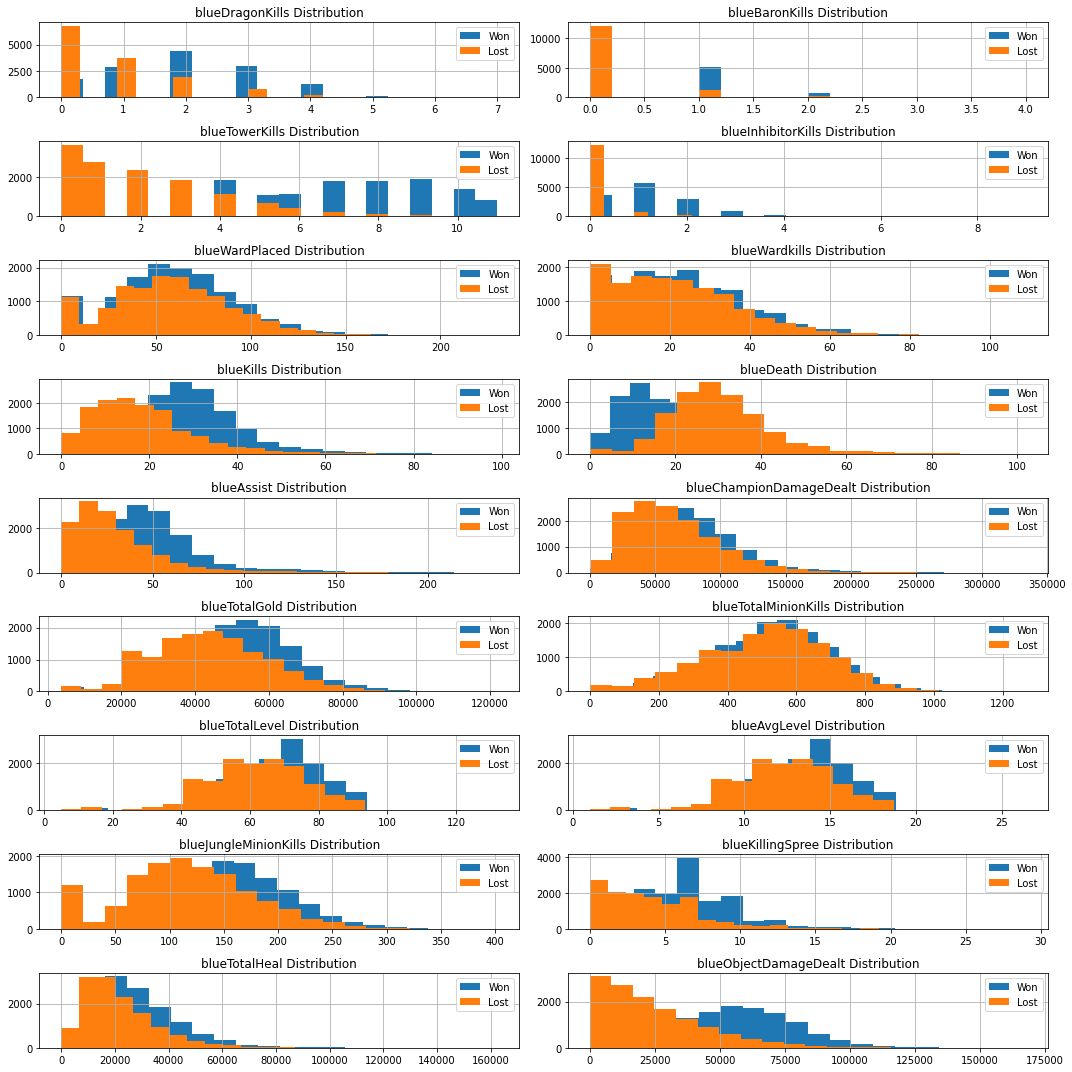

In [ ]:
compare_histograms(histogram_data_win, histogram_data_lose, histogram_data_win, 9, 2)

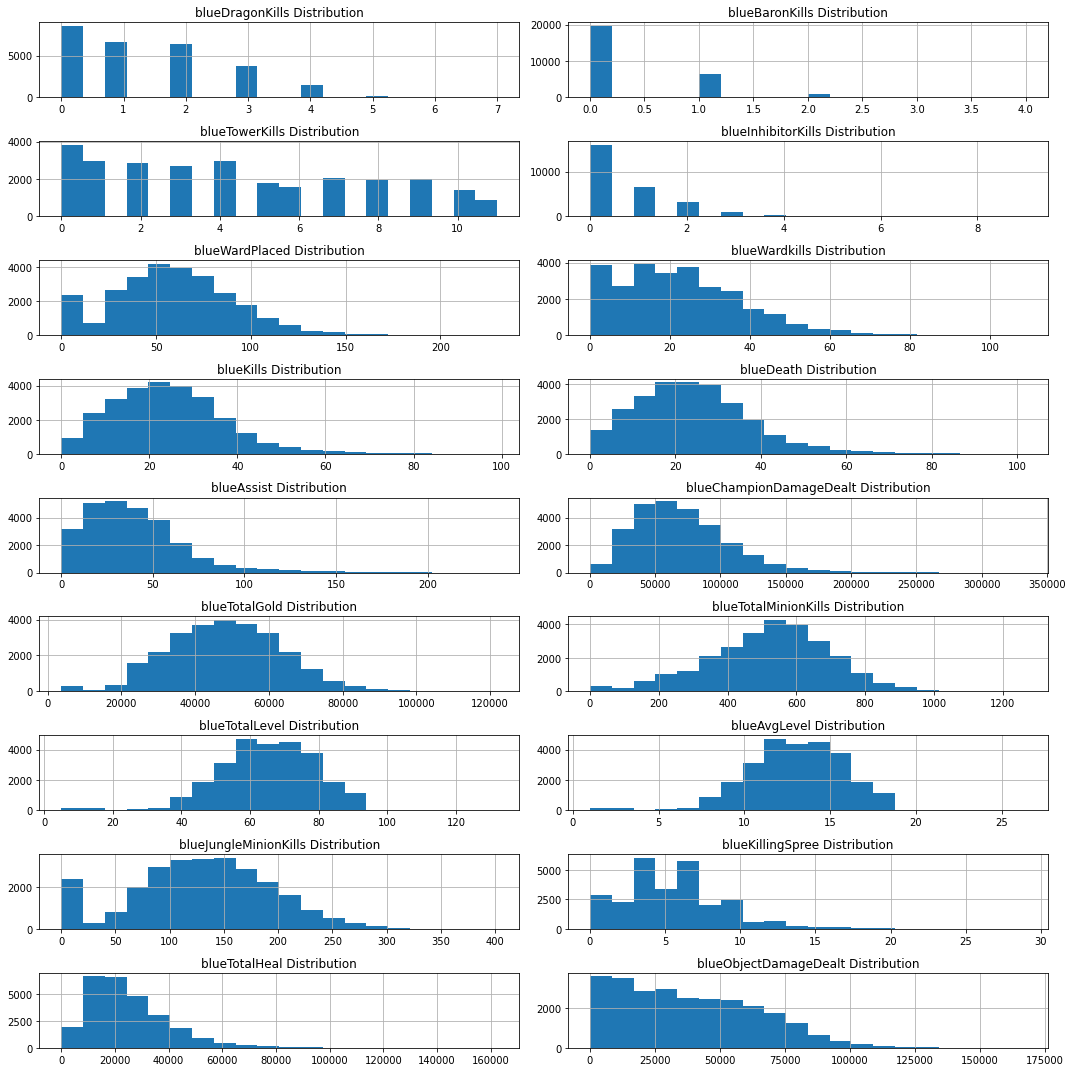

In [ ]:
draw_histograms(histogram_all, histogram_all.columns, 9, 2)

### QQ Plots


  * Right skewed variables, shown to have light left tails, and heavy right tails

  
  * Notable Variables:
    * Total minion kills
      * looks to be the most normally distributed variable out of all
    * Champion damage dealt/assists/ total heal 
      * will need/benefit most with a transformation to a normal distribution
    * Total level
      * Both left and right tails are heavy
      * Majority of variables distributed near median


In [ ]:
import pylab 
def draw_qqplots(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,15))
    for i, var_name in enumerate(variables):
        
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        stats.probplot(df[var_name], dist="norm", plot=pylab)
        # df[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name+" qq plot")
        plt.tight_layout()
    
    plt.show()

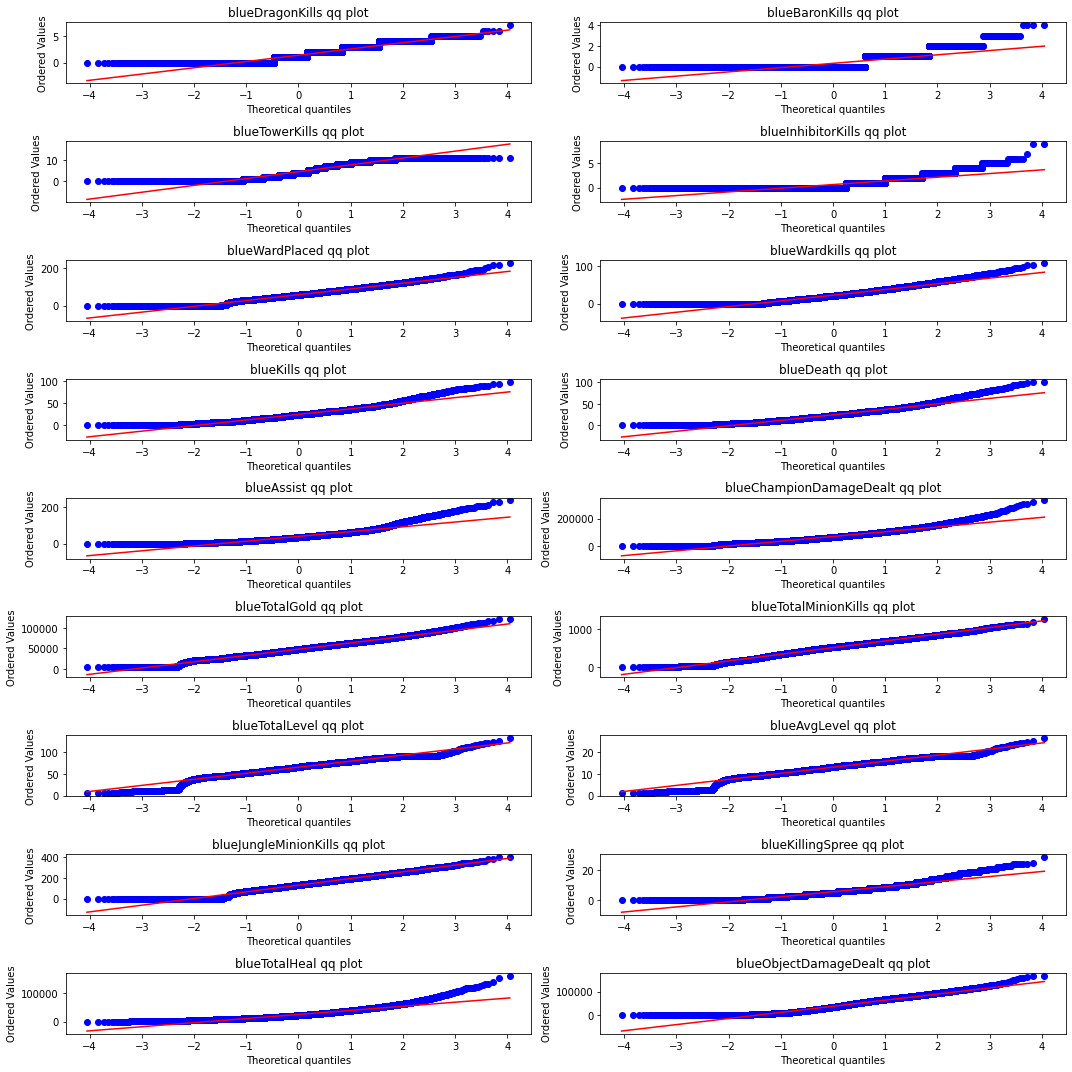

In [ ]:
draw_qqplots(histogram_all, histogram_all.columns, 9, 2)

### Pie Charts

---
  * Note: Pie charts were chosen to better visualize variables that were either binary, or had a narrow range of values
---


  * Including both win and lost games (i.e. all games):
    * Equal chance for both teams to get first blood
    * First dragon is prioritized greater than first baron
    * It is rare to observe 4+ dragons slain
    * There is an uniform distribution of tower kills


  * Notable Comparisons:
    * For binary variables, won games secure the objective more often than lost games
    * It is more likely to capture a total of 1 dragon in lost games than won games
    * The frequency of capturing 2+ dragons differs greatly between won and lost games
    * Tower kills in won games have a uniform distribution, whereas lost games have majority of its data split between: 0, 2, and 6
    * In both won and lost games, 0 barons captured most frequent


In [ ]:
piechart_col_names = [c for c in df_test_clean.columns if c.lower()[4:9] == "first"]
# piechart_col_names = piechart_col_names + ["blueDragonKills", "blueBaronKills", "blueTowerKills", "blueInhibitorKills"]
piechart_all = df_train_clean[piechart_col_names]
piechart_all.head()

,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,1,1,0
4,1,1,1,1,1


In [ ]:
piechart_win = win_stats[piechart_col_names]
piechart_loss = loss_stats[piechart_col_names]

In [ ]:
def draw_piecharts(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        percentages = list(df[var_name].value_counts(normalize=True, sort=False) * 100)
        labels = sorted(df[var_name].unique())
        explode = ([0.02] * len(percentages))
        ax.pie(percentages,shadow=True, explode=explode, labels=labels, autopct='%1.1f%%')
        ax.set_title(var_name)

        ax.legend(
          title="# of occurances",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels, percentages)]
          )
        plt.tight_layout()
    
    plt.show()

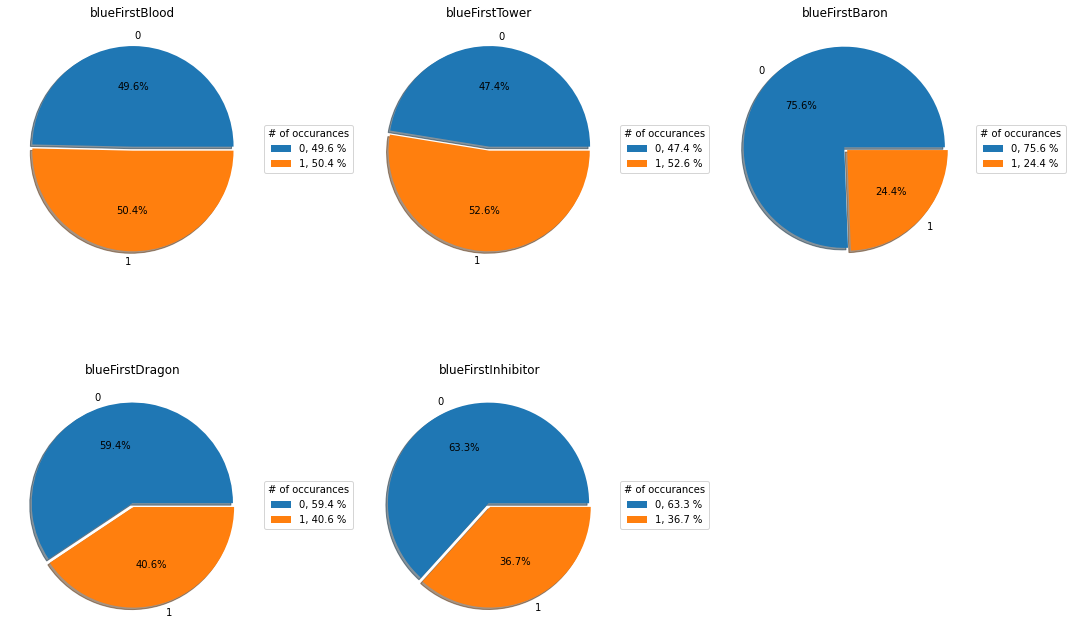

In [ ]:
draw_piecharts(piechart_all, piechart_all.columns, 3, 3)

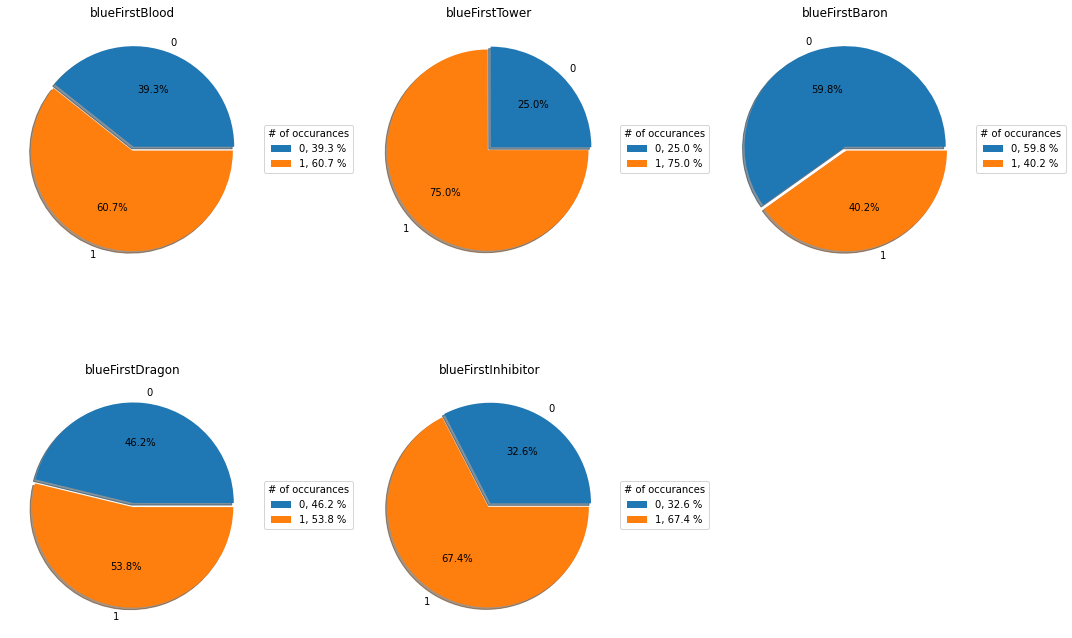

In [ ]:
draw_piecharts(piechart_win, piechart_win.columns, 3 ,3)

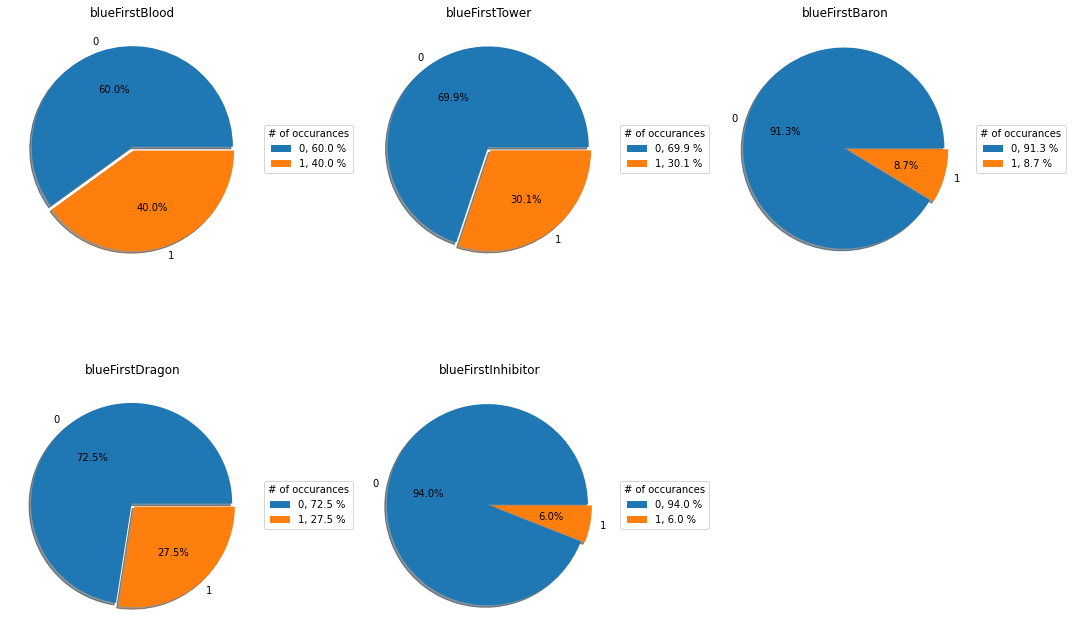

In [ ]:
draw_piecharts(piechart_loss, piechart_loss.columns, 3 ,3)

## Further Skew Calculation


  * Skew calculation found here: **https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html**


  * **Majority of the variables have moderate skewness** based on calculation

  
  * Notable Variables:
    * Assist has most of its weight in the left tail
      * Also true for total heal
    * Total level has	most of its weight in the right tail

In [ ]:
histogram_all.skew() # from scipy.stats library

blueDragonKills            0.534823
blueBaronKills             1.641206
blueTowerKills             0.336836
blueInhibitorKills         1.596076
blueWardPlaced             0.197140
blueWardkills              0.668777
blueKills                  0.781307
blueDeath                  0.802141
blueAssist                 1.503434
blueChampionDamageDealt    0.955603
blueTotalGold              0.084302
blueTotalMinionKills      -0.268591
blueTotalLevel            -0.568194
blueAvgLevel              -0.568194
blueJungleMinionKills     -0.095157
blueKillingSpree           0.959105
blueTotalHeal              1.392341
blueObjectDamageDealt      0.518291
dtype: float64

# Preparing the Data for Analysis

## Key Points of Data Preparation: 


  * By normalizing the data via Box-Cox transformation, severely skewed variables appear closer to a normal distribution
   * Confirmed by skewness calculation, histograms, and QQ plots


  * Total level, average level, and total gold had enormous interaction with other variables and have been removed


  * Killing spree and assists are indirect measures of total kills and were removed due to redundancy 


  * Variables for further analysis: 
    * Numerical Varaibles: 
        * blueWardPlaced
        * blueWardkills
        * blueKills
        * blueDeath
        * blueChampionDamageDealt
        * blueTotalMinionKills
        * blueJungleMinionKills
        * blueTotalHeal
        * blueObjectDamageDealt
    
    * Binary Variables:
        * blueFirstBlood
        * blueFirstTower
        * blueFirstBaron
        * blueFirstDragon
        * blueFirstInhibitor


## Normalizing Data

Normalizing data is one of the methods in preprocessing data. Normalization tackles multiple problems when analyzing raw data. 



> The first problem is the differences of scales between variables. This is a problem because **larger scales will have a larger influence** on for example, a multivariate analysis, when that factor may not be an important predictor. When all variables are measured on the same scale, each variable is equally important when under analysis. 

> The second problem is skewed data/heteroskedasticity. With skewed data, there is **larger variability in the skewed region**. This is a problem in linear regression because for the **effect of the variable on the result will be enhanced** for values in the skewed region

> By normalizing, the variability becomes constant and the effect of the variable is true for all values.
Additionally, the statistical done to this dataset assumes normal distribution.

***
  > More information about:

1. [Benfits of normalizing data](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)


2. [Benefits of normalizing data 2](https://blog.minitab.com/blog/applying-statistics-in-quality-projects/how-could-you-benefit-from-a-box-cox-transformation)


3. [Skewness](https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis#:~:text=As%20a%20general%20rule%20of,the%20distribution%20is%20approximately%20symmetric.)

  




In [ ]:
from sklearn import preprocessing
def normalize_data(df):
  df = df+1
  scaler = preprocessing.PowerTransformer(method="box-cox", standardize=True).fit(df)
  norm_df = pd.DataFrame(scaler.transform(df),columns=df.columns)
  return norm_df

  > Here the data was normalzied with a Box-Cox transformation - a power transformation. 

  > As a result, the both problems were resovled:
  1. all variables fit within a scale between -1 and 1
   * larger scaled variables will not longer have a larger influence in a model

  2. variables are closer to a normal distribution
  
  
   More information about:
  * [Box-Cox transformations](http://onlinestatbook.com/2/transformations/box-cox.html)

  * [Box-Cox transforamtions using sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html)

In [ ]:
norm = normalize_data(histogram_all)
norm.head()

,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,-1.273762,-0.610294,-1.604084,-0.812672,-0.585193,-0.455082,-0.643811,0.605658,-0.555753,-0.273156,-0.715576,-0.489550,-0.708176,-0.708204,-0.316278,-0.322395,0.557704,-1.430611
1,0.650775,-0.610294,0.073419,-0.812672,0.018790,-0.106030,-0.293112,-1.360776,-0.140887,-0.146153,-0.450563,0.030610,-0.216857,-0.218021,-0.225224,-0.668255,0.271810,0.424471
2,-1.273762,-0.610294,-1.604084,-0.812672,-0.927724,-0.957188,-1.756685,-0.205242,-1.479241,-1.452638,-1.644060,-1.223078,-1.583931,-1.580458,-0.964642,-2.175867,-1.565105,-1.432762
3,-0.097276,1.624900,-0.593170,-0.812672,2.017493,1.046643,0.253398,0.932018,0.381525,0.929226,0.985784,1.486943,1.112790,1.112639,1.405493,-0.668255,0.160791,-0.070922
4,0.650775,1.730378,1.633690,1.616694,1.626395,0.852542,0.326097,1.179157,0.447810,1.645919,1.714147,1.840481,1.366507,1.367244,1.752688,-0.012178,0.897852,1.717333


In [ ]:
norm.skew()

blueDragonKills           -0.037321
blueBaronKills             1.029092
blueTowerKills            -0.138810
blueInhibitorKills         0.469726
blueWardPlaced            -0.249052
blueWardkills             -0.162045
blueKills                 -0.003913
blueDeath                 -0.002884
blueAssist                 0.013453
blueChampionDamageDealt    0.047261
blueTotalGold              0.023121
blueTotalMinionKills      -0.074405
blueTotalLevel             0.008545
blueAvgLevel               0.014357
blueJungleMinionKills     -0.421500
blueKillingSpree          -0.008861
blueTotalHeal              0.052100
blueObjectDamageDealt     -0.233067
dtype: float64

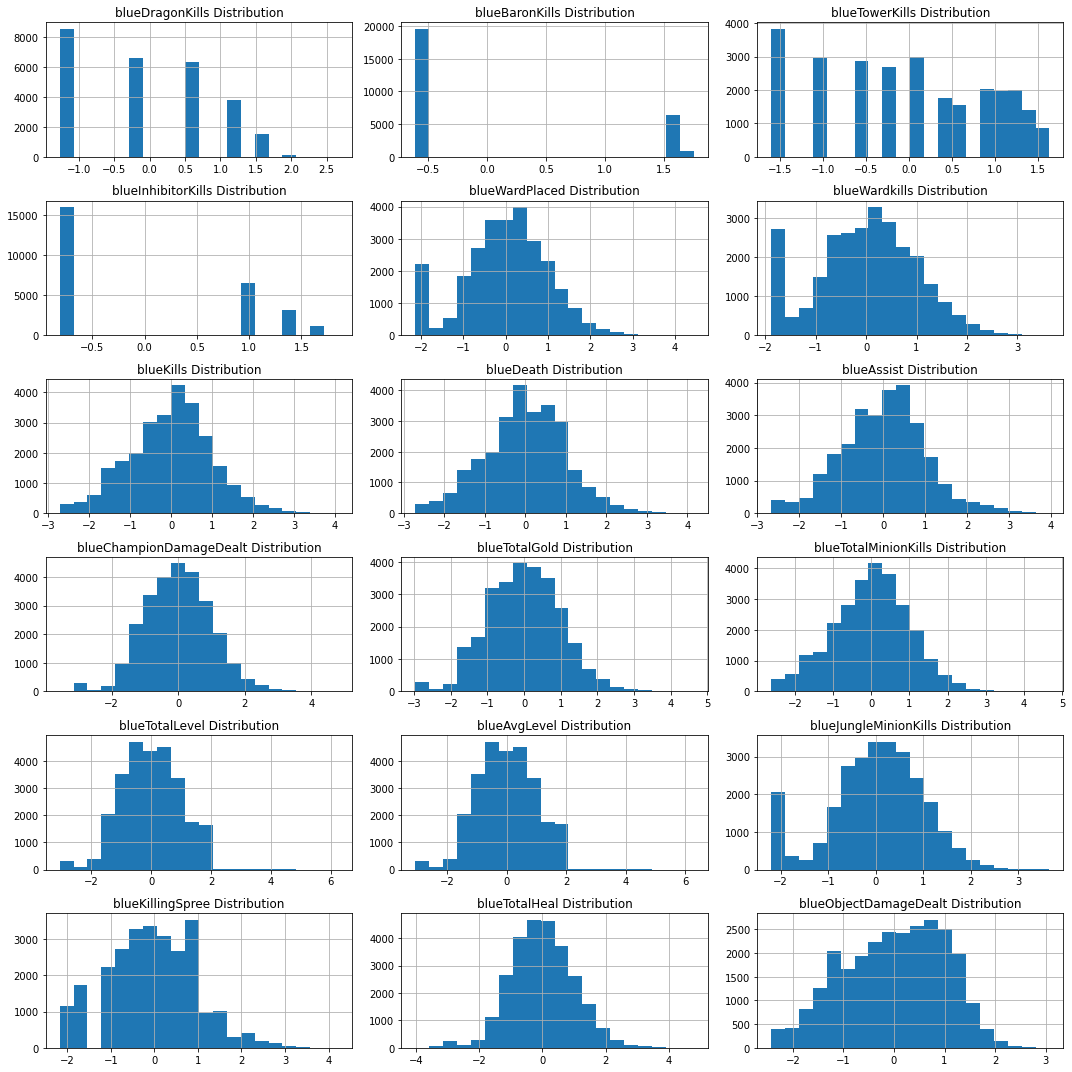

In [ ]:
draw_histograms(norm, norm.columns, 6, 3)

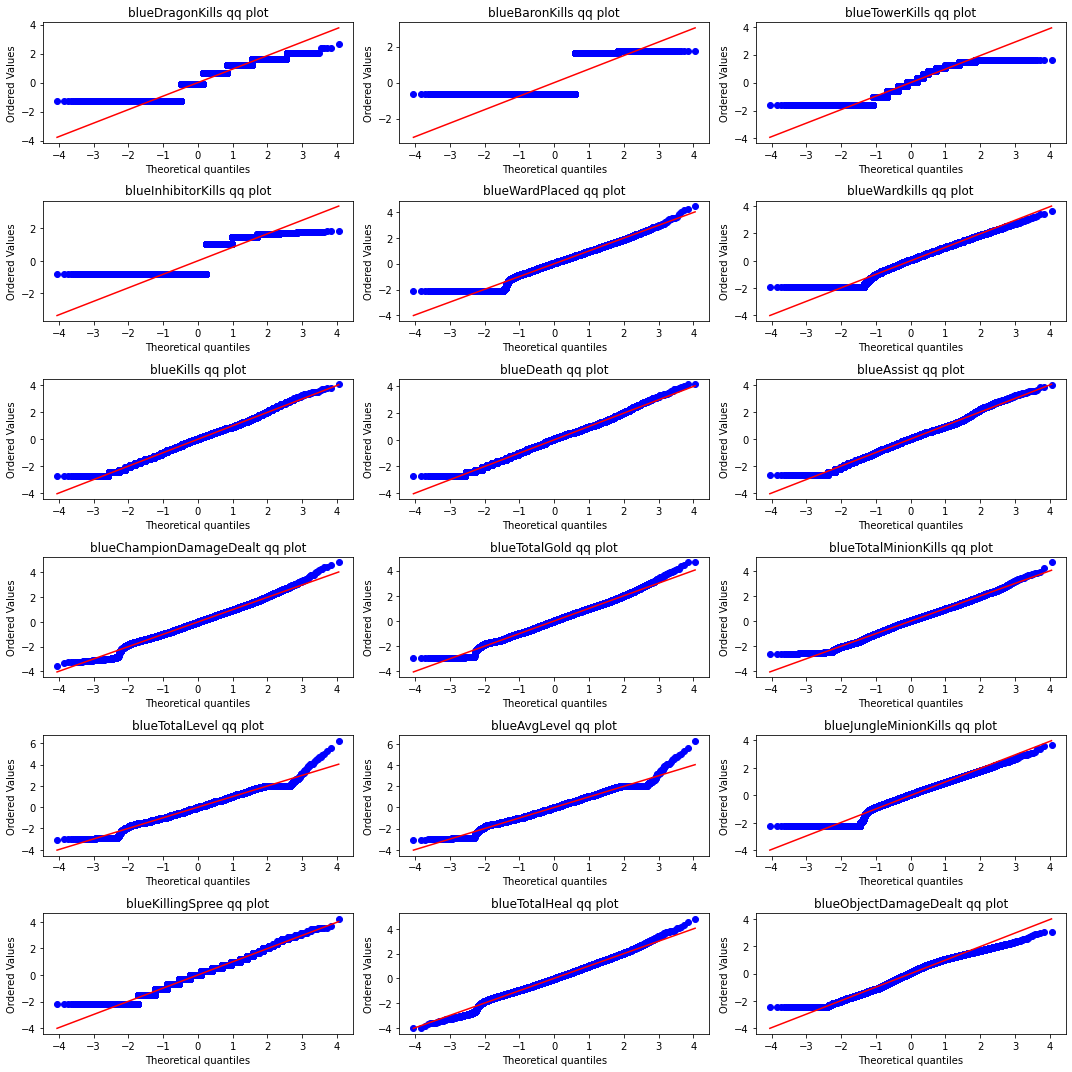

In [ ]:
draw_qqplots(norm, norm.columns, 6, 3)

## Testing for Multicollinearity

### What is Multicollinearity?

  > Multicollinearity is the interaction between independent variables. It can be **measured by calculating the variance inflation factor (VIF)** and **visualized with a correlation matrix**. 
  
  > Additionally, VIF scores are only applicable to **ordinary least square** models. Whereas, correlation matrices are applicable to a wider range of models.


  > The greater a VIF is, the greater correlation it has with other variables. As a guideline, VIF >= 10 is most problematic because the less reliable that variable is in predicting an outcome. 
  * More info about: 
    * [Variance inflation factors (VIFs)](https://www.displayr.com/variance-inflation-factors-vifs/#:~:text=The%20higher%20the%20value%2C%20the,being%20regarded%20as%20very%20high.&text=If%20one%20variable%20has%20a,must%20also%20have%20high%20VIFs.)
    * [VIF Wiki](https://en.wikipedia.org/wiki/Variance_inflation_factor)
    * [Corrrelation Wiki](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices)



### Variance Inflation Factor
  
  >  

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
vif_init = calc_vif(norm)
vif_init

,variables,VIF
0,blueDragonKills,3.021441
1,blueBaronKills,2.023520
2,blueTowerKills,9.669008
3,blueInhibitorKills,3.474475
4,blueWardPlaced,8.255314
5,blueWardkills,7.148002
6,blueKills,18.046342
7,blueDeath,4.584961
8,blueAssist,9.983867
9,blueChampionDamageDealt,16.834729


  > Total level, average level, and total gold have an enormous VIF, this means these variables are highly associated with other variables.


  > These will be removed to reduce the VIF of other variables and we can get closer to the true VIF scores.

  > Additionally, killing spree and assist are **indirect measures of total kills and is redundent**. Therefore, **killing spree and assists were removed** from further analysis.

In [ ]:
norm2 = norm.drop(["blueTotalLevel", "blueAvgLevel", "blueTotalGold", "blueKillingSpree", "blueAssist"], axis=1)
vif_norm2 = calc_vif(norm2)
vif_norm2

,variables,VIF
0,blueDragonKills,3.019687
1,blueBaronKills,1.884952
2,blueTowerKills,9.024301
3,blueInhibitorKills,3.324508
4,blueWardPlaced,7.883234
5,blueWardkills,6.710674
6,blueKills,7.515469
7,blueDeath,3.669368
8,blueChampionDamageDealt,13.168565
9,blueTotalMinionKills,10.298260


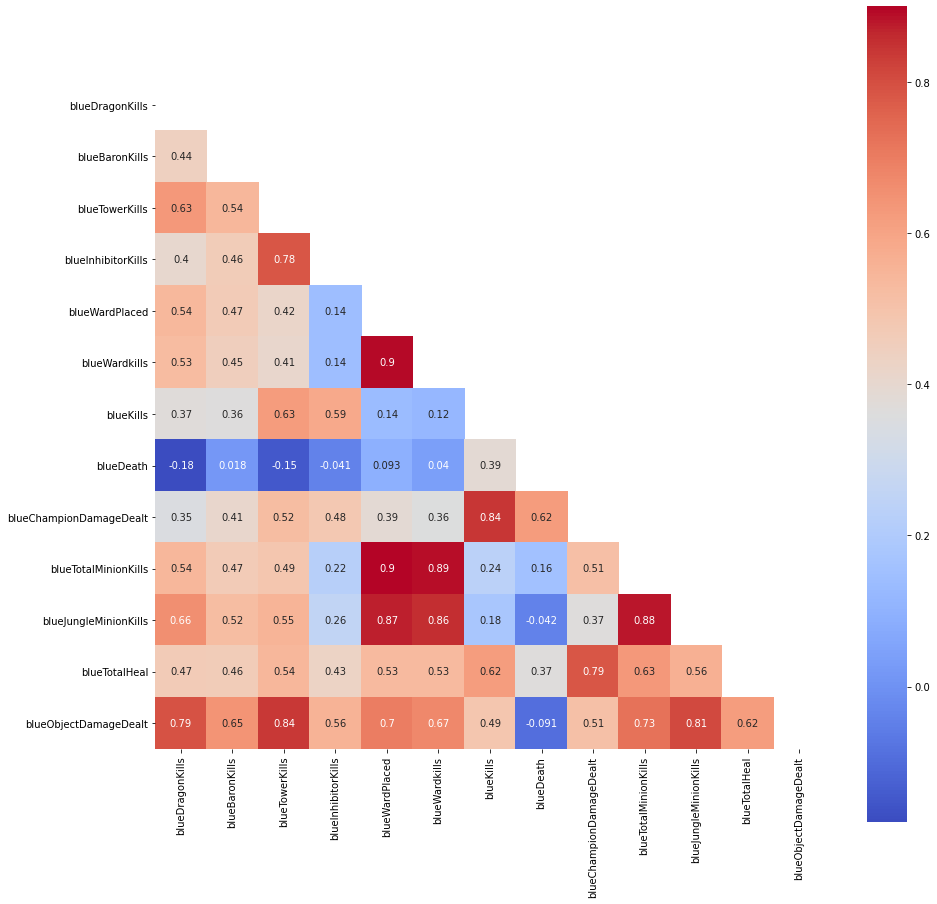

In [ ]:
import seaborn as sn
corr_matrix_norm = norm2.corr()
mask = np.triu(corr_matrix_norm)
f, ax = plt.subplots(figsize=(15,15))
ax = sn.heatmap(corr_matrix_norm, annot=True, mask=mask, cmap="coolwarm", square=True)
plt.show()

  > The **lower the number in the correlation matrix, the lower interaction** between the two variables. 


  > Some notable interactions: 
  * Total minion kills - ward kills
  * Total minion kills - wards placed


  > It is not as clear to why these variables are associated with each other, usually in game, minion kills and ward kills/placed are seen as independent. It raises the question: **Why do minion kills associate with ward kills/placed?** 


# Modelling the Data

### Key points of Modelling the Data: 
  * **logistic modelling** is best to represent the data
  * the following variables **are statistically significant**, and are included in modelling the data:
    * Numerical Variables: 
      * blueDragonKills         
      * blueTowerKills          
      * blueWardPlaced           
      * blueWardkills            
      * blueKills                
      * blueDeath                
      * blueTotalMinionKills     
      * blueJungleMinionKills   
      * blueObjectDamageDealt

    * Binary Varaibles: 
      * blueFirstBlood         
      * blueFirstTower          
      * blueFirstBaron           
      * blueFirstInhibitor
    

  * these variables will be observed when predicting the win probability of a game

## Choosing A Model to Represent the Data

### Which Model is Best? 
  > Given that the outcome is binary (i.e.) 0 = lose, 1 = win), a **logistic regression model** is best. 

### Why not Linear Regression? 
  > Linear regression **assumes that the response variable is continuous**. For example, if we were to graph a curve where total gold is on the X-axis, and win or lose on the Y-axis, there would be a sigmoidal curve, an S-shaped curve. This curve certainly does not show a linear relationship, therefore, linear regression wouldn’t be a good model for the data. 

### What is Logistic Regression?

  > Logistic regression models the probability of a true or false outcome, in this case the outcome is win or lose. This model is **best for classification**, and can be given a threshold to differentiate a true from or false prediction. 
  
  > The model is built similar to a linear regression model, where the predictor variables can be nominal, continuous, and categorical,
 and with a log(odds) transformation, predicts which group the data point belongs to.



![Logistic Regression Curve](https://miro.medium.com/max/725/1*QY3CSyA4BzAU6sEPFwp9ZQ.png)

More information about:

  * [What is Logistic Regression?](https://www.youtube.com/watch?v=yIYKR4sgzI8)
  * [How Logistic Regression is used](https://www.statisticssolutions.com/what-is-logistic-regression/#:~:text=Like%20all%20regression%20analyses%2C%20the,or%20ratio%2Dlevel%20independent%20variables.)

## Identifying Significant Variables


### Important Terminology: 
#### P-Values:
  > P-values indicate if the variable has an effect on the outcome variable. In other words, we set that variable to a value of 0 - if it makes a difference in the outcome, then it has an effect on the model.
	
  > When the variables P-value > 0.05, it is removed because it does not make a difference in predicting the outcome. Variables with a P-value < 0.05, they are retained in the model because removing it changes the predicted outcome. 

#### Maximum Likelihood Estimation (MLE):
  > MLE determines the parameters for each variable in the model, where it maximizes the likelihood of fitting predicted value to the observed value. These values can be determined by iterating through values and picking the model that has the least amount of error.
	
  > This is similar to fitting data using least squares in linear regression, except the data is projecting on a log(odds) line to find the least squares, then it is translated back into probability values and log(likelihood). 

#### Pseudo R<sup>2</sup> Value:
  > R<sup>2</sup> measures how well the model fits with the current data. It ranges from 0 to 1, the closer it is to 1, the better the model represents the data. 
---
More information about:
  * [P-values](https://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients#:~:text=The%20p%2Dvalue%20for%20each,can%20reject%20the%20null%20hypothesis.&text=Typically%2C%20you%20use%20the%20coefficient,keep%20in%20the%20regression%20model.)
  * [Maximum Likelihood Estimation (MLE)](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1)
  * [Pseudo R<sup>2</sup> values](https://thestatsgeek.com/2014/02/08/r-squared-in-logistic-regression/)
  * [Video explaination of P-values and R<sup>2</sup> values](https://www.youtube.com/watch?v=xxFYro8QuXA)
  * [Video explaination of MLE](https://www.youtube.com/watch?v=BfKanl1aSG0)

## Creating A Logistic Model

  ### First Model
  
  * for the first model, all the variables from the clean dataset were included
  #### P-Values:
    * the following had p-values > 0.05 and will be removed: 
        * blueFirstTower
        * blueFirstBaron
        * blueWardkills
        * blueTotalHeal
        * blueFirstDragon
        * blueBaronKills
        * blueChampionDamageDealt
        * blueTotalMinionKills
        * blueTotalHeal
        * blueObjectDamageDealt
    * all other variables are significant to the model

  ### R<sup>2</sup> Value:
    * surprisingly, the first model has a high R<sup>2</sup> value of 0.8462



In [ ]:
norm_X_train = piechart_all.join(norm2) # join categorical with numerical variables
X = norm_X_train.to_numpy()
Y = y_train
model = sm.Logit(Y,X).fit()
predictions = model.predict(X)
print_model = model.summary(xname=list(norm_X_train.columns))
print(print_model)

Optimization terminated successfully.
         Current function value: 0.092756
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               blueWins   No. Observations:                26904
Model:                          Logit   Df Residuals:                    26886
Method:                           MLE   Df Model:                           17
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.8662
Time:                        17:33:19   Log-Likelihood:                -2495.5
converged:                       True   LL-Null:                       -18648.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
blueFirstBlood             -0.3965      0.072     -5.531      0.000      -0.537  

### Refining the First Model
  
  * for the second model, all the variables are statistically significant ((i.e.) p-values < 0.05). 
  #### R<sup>2</sup> Value: 
    * R<sup>2</sup> value did not decrease drastically, supporting the notion that removing insignificant variables had no effect on the models fit of the data.

In [ ]:
logit_insig = ["blueFirstTower", "blueFirstBaron", "blueWardkills", "blueChampionDamageDealt", "blueTotalMinionKills", "blueTotalHeal", "blueObjectDamageDealt"]
X = norm_X_train.drop(list(logit_insig), axis = 1)
Y = y_train
model = sm.Logit(Y,X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)

Optimization terminated successfully.
         Current function value: 0.092973
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               blueWins   No. Observations:                26904
Model:                          Logit   Df Residuals:                    26893
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.8659
Time:                        17:33:19   Log-Likelihood:                -2501.3
converged:                       True   LL-Null:                       -18648.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
blueFirstBlood           -0.4624      0.067     -6.861      0.000      -0.595      -0

#### Displaying Significant Stats 

  * Note: feel free to look into the significant stats in won and lost games
    * there were NaN values because the win and lost values in "blueWins" was joined with the win and lost groups.
    * those said NaN rows were removed for a cleaner view

In [ ]:
blue_sig_stats = norm_X_train

blue_sig_stats["blueWins"] = y_train
blue_sig_stats.head()

,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt,blueWins
0,1,0,0,0,0,-1.273762,-0.610294,-1.604084,-0.812672,-0.585193,-0.455082,-0.643811,0.605658,-0.273156,-0.489550,-0.316278,0.557704,-1.430611,0
1,0,0,0,1,0,0.650775,-0.610294,0.073419,-0.812672,0.018790,-0.106030,-0.293112,-1.360776,-0.146153,0.030610,-0.225224,0.271810,0.424471,1
2,0,0,0,0,0,-1.273762,-0.610294,-1.604084,-0.812672,-0.927724,-0.957188,-1.756685,-0.205242,-1.452638,-1.223078,-0.964642,-1.565105,-1.432762,0
3,0,0,1,1,0,-0.097276,1.624900,-0.593170,-0.812672,2.017493,1.046643,0.253398,0.932018,0.929226,1.486943,1.405493,0.160791,-0.070922,0
4,1,1,1,1,1,0.650775,1.730378,1.633690,1.616694,1.626395,0.852542,0.326097,1.179157,1.645919,1.840481,1.752688,0.897852,1.717333,1


In [ ]:
blue_wins = blue_sig_stats.where(df_train["blueWins"] == 1)
blue_wins = blue_wins.dropna()
blue_wins.head()

,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt,blueWins
1,0.0,0.0,0.0,1.0,0.0,0.650775,-0.610294,0.073419,-0.812672,0.018790,-0.106030,-0.293112,-1.360776,-0.146153,0.030610,-0.225224,0.271810,0.424471,1.0
4,1.0,1.0,1.0,1.0,1.0,0.650775,1.730378,1.633690,1.616694,1.626395,0.852542,0.326097,1.179157,1.645919,1.840481,1.752688,0.897852,1.717333,1.0
5,1.0,1.0,0.0,0.0,1.0,0.650775,-0.610294,1.052824,1.006979,0.259821,0.204880,0.253398,-0.371636,-0.158170,0.293399,0.648317,1.090102,0.625091,1.0
7,1.0,1.0,1.0,0.0,1.0,0.650775,1.624900,1.450118,1.440243,0.667341,1.046643,0.935342,-0.205242,0.948670,0.511991,0.449663,0.411870,1.055493,1.0
8,1.0,1.0,1.0,0.0,1.0,1.210262,1.624900,1.052824,1.006979,0.949103,1.831506,0.253398,0.182267,0.328780,1.058550,0.262628,0.479818,1.031091,1.0


In [ ]:
blue_loses = blue_sig_stats.where(df_train["blueWins"] == 0)
blue_loses = blue_loses.dropna()
blue_loses.head()

,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt,blueWins
0,1.0,0.0,0.0,0.0,0.0,-1.273762,-0.610294,-1.604084,-0.812672,-0.585193,-0.455082,-0.643811,0.605658,-0.273156,-0.489550,-0.316278,0.557704,-1.430611,0.0
2,0.0,0.0,0.0,0.0,0.0,-1.273762,-0.610294,-1.604084,-0.812672,-0.927724,-0.957188,-1.756685,-0.205242,-1.452638,-1.223078,-0.964642,-1.565105,-1.432762,0.0
3,0.0,0.0,1.0,1.0,0.0,-0.097276,1.624900,-0.593170,-0.812672,2.017493,1.046643,0.253398,0.932018,0.929226,1.486943,1.405493,0.160791,-0.070922,0.0
6,0.0,1.0,0.0,0.0,0.0,-1.273762,-0.610294,-0.593170,-0.812672,0.465658,0.377946,-0.552833,0.605658,0.140672,0.440855,0.146186,-0.139908,-0.041651,0.0
10,1.0,0.0,0.0,0.0,0.0,-1.273762,-0.610294,-1.604084,-0.812672,-1.957146,-1.888711,-2.454511,-2.717929,-2.973099,-2.496906,-1.912464,-3.080061,-2.433671,0.0


# Predicting Win Probability

### Key points of Predicting Win Probability: 
  * after testing the model with Master tier games, the model achieved an accuracy of 96%!
  * columns have been labelled as numerical or categorical for the tensorflow model


## Background Info About TensorFlow Modelling


### Using a Linear Classification Model to Predict Win Probability
  > The probability of winning can take on values from 0 to 1 and NOT of values of 0 and 1. In other words, the probability is a continuous outcome, and not a binary outcome.
		
  > In the previous section, a logistic model was chosen to model the data because the outcome was binary and more importantly, it was given i.e.) win or loss. Therefore the p-values that identify the significant variables, or in other words the variables that influence winning, are credible. 
  
  > These significant variables will be used to create a linear classification model to predict the win probability of a game.

### How the data needs to be formatted for TensorFlow
  > Depending on how the variable is measured and encoded, the numbers can have different meanings. For example a categorical variable such as color, can encode 1 for red, 2 for blue, etc., but 1 < 2 does not make sense. In comparison to a numerical variable such as heart rate, 160BPM > 150BPM does make sense

* Note: BPM = beats per minute 
	

  > Tensorflow has estimators that use a “feature column” system.Each variable must be specified as categorical, numerical, etc., such that the model will know how to interpret the data for each feature. 


### Creating the TensorFlow Pipeline
  > A pipeline feeds data to the model in parts called ‘batches’. Everytime a batch is fed into the model, the parameters update to better fit the data. In other words, the more data exposed to the model, the more optimization made to the model. 


## Formatting Data for Tensorflow

In [ ]:
INSIG_VARS = logit_insig
SIG_BIN_CAT_VARS = [v for v in list(piechart_all.columns) if v not in INSIG_VARS]
SIG_NUM_VARS = [v for v in list(histogram_all.columns) if v not in INSIG_VARS]
ALL_SIG_VARS = SIG_BIN_CAT_VARS + SIG_NUM_VARS

 Instead of hard coding the significant variables, I looped over the groups of variables and only included the ones that are significant

In [ ]:
def format_test_data(df):
    df = df.head(26904)
    bin_data = df[SIG_BIN_CAT_VARS]
    # normalize numerical variables
    num_data = df[SIG_NUM_VARS]
    norm_num_data = normalize_data(num_data)
    win_loss_col = df["blueWins"]
    test_data = pd.concat([bin_data, norm_num_data, win_loss_col], axis=1)
    return test_data

In [ ]:
def format_train_data(df):
    df = df.head(26904)
    bin_data = df[SIG_BIN_CAT_VARS]
    # normalize numerical variables
    num_data = df[SIG_NUM_VARS]
    norm_num_data = normalize_data(num_data)
    test_data = pd.concat([bin_data, norm_num_data], axis=1)
    return test_data

Here I formatted the datasets by: 
  1. getting the significant variable columns
  2. normalizing only the numerical variables
  3. attaching the binary and categorical variables
    * these were not transformed
  4. attaching the results/labels, indicating if blue team won or lost
    * this was only done for the test data

In [ ]:
clean_train_data = format_train_data(df_train)
clean_test_data = format_test_data(df_test)
clean_test_data.head()

,blueFirstBlood,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueKills,blueDeath,blueAssist,blueTotalGold,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueWins
0,1,0,0,-1.314288,-0.615599,0.083842,-0.809645,0.643078,-1.414126,-0.223136,-0.999199,-0.292813,-0.322768,-0.324522,0.792249,-1.004124,0
1,0,0,0,-1.314288,-0.615599,-0.216549,-0.809645,-0.373689,-1.537693,0.033586,-1.301794,-0.687299,-0.601928,-0.602871,-0.185536,-1.472373,0
2,0,1,1,-0.151242,1.607743,1.231125,1.456484,0.348583,0.679850,-0.781112,1.037540,0.777596,0.759421,0.758229,1.241571,0.664217,1
3,1,1,0,0.614306,-0.615599,0.352324,-0.809645,-0.022777,0.373066,-1.968399,0.093923,-0.643838,-0.802257,-0.802386,-0.468338,0.381470,1
4,1,1,0,0.614306,-0.615599,-0.216549,-0.809645,0.643078,-0.205947,0.198313,-0.461998,-0.261047,-0.322768,-0.324522,-0.569523,0.079629,0


## Feature Engineering for TensorFlow Model

In [ ]:
feature_columns = []
y_test_clean = clean_test_data.pop("blueWins")

for feature_name in SIG_BIN_CAT_VARS:
  vocabulary = clean_train_data[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in SIG_NUM_VARS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

This is where the significant variables are labelled as categorical, or numerical
  * more info can be found in the background information in this section

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=100):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return (ds)  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(clean_train_data, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(clean_test_data, y_test_clean, num_epochs=1, shuffle=False)


Here is the pipeline that supplies the TensorFlow model with data. It includes:

  * values of the features
  * corresponding labels
  * feeds 100 points at a time

In [ ]:
ds = make_input_fn(clean_train_data, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of blueDragonKills:', feature_batch['blueDragonKills'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

This is an example of what a single input from a batch looks like

## Testing the Model and Results

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns= feature_columns)
# We create a linear estimator by passing the feature columns we created earlier

The linear model is created using the feature columns specified previously

In [ ]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result)  # the result variable is simply a dict of stats about our model

Surprisingly, the model has an **accuracy of ~96%**

# TensorFlow Model Learning Perfomance

### Key points of Predicting Win Probability: 
  * given the accuracy of the model, predicted probabilties have a bimodal distrbution, with peaks at 0 and 1. 

  * the model has a low false positive rate, and a high true positive rate
    * as shown with the logarithmic ROC curve

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnvytrjkh/model.ckpt-8370
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


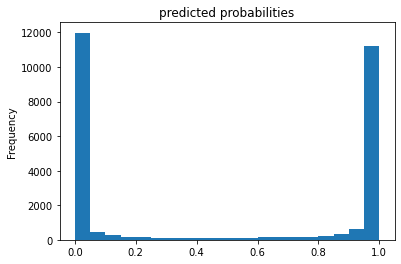

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

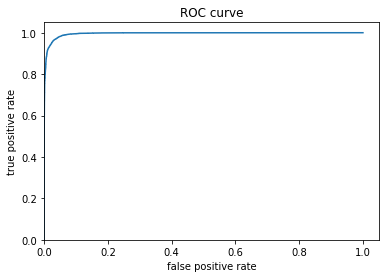

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_test_clean, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)